In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

%matplotlib inline

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# Customer distribution by country

country_cus_data = df[['Country', 'CustomerID']].drop_duplicates()
country_cus_data.groupby('Country')['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [7]:
# Performing filtering opration on only United Kingdom data
df = df.query("Country == 'United Kingdom'").reset_index(drop=True)

In [8]:
# Checking the missing values in the dataset
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

## Removing the null values

* We can ignore the missing values from the Description column but we cannot ignore the missing values from the CustomerID column.

In [9]:
# Getting rid of missing values from the CustomerID column 
df = df[pd.notnull(df['CustomerID'])]

### Checking if there are any negative value in the Quantity column. Because quantity cannot be negative(-ve) it can be zero.

In [10]:
df.Quantity.min()

-80995

### Checking if there are any negative values in UnitPrice  column.

In [11]:
df.UnitPrice.min()

0.0

* As you saw from the above cell there are **-80995** negative values so we need to clean this Quantity related data. So we will filter out all the negative records having negative values for the quantity column.

In [12]:
df = df[(df['Quantity'] > 0)]

### Converting the InvoiceDate column to datetime format

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Adding a new column depicting the TotalAmount

In [14]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [15]:
df.shape

(354345, 9)

# RFM modelling

* We will be calculating **Recency**, **Monetary** & **Frequency** values of each customers from the dataset we have.

Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total 
Amount for each customer

In [16]:
# Importing the datetime library
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. 
#This is to calculate the number of days from recent purchase

Latest_Date = dt.datetime(2011,12,10)




### Creating the RFM modelling scores for each customers

* In this we are first grouping all the transactions using CustomersID's and then we are using aggerate method. Inside this we are using a lambda function which subtracts maximum invoice number from latest date from which we'll get a numner which depicts the **recency**.
* The lambda function is calculating the **frequency**  based on **InvoiceNo** which is associated with transactions done by specific customer 
* The last lambda function calculates the **TotalAmount** for each customer which represent's how much a customer has spent till the date.

In [17]:
rfm_scores = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x : (Latest_Date - x.max()).days, 
    'InvoiceNo' : lambda x : len(x),
    'TotalAmount' : lambda x : x.sum()
})

### Converting the InvoiceDate feature into int type

In [18]:
rfm_scores['InvoiceDate'] = rfm_scores['InvoiceDate'].astype(int)

In [19]:
rfm_scores.head()

,InvoiceDate,InvoiceNo,TotalAmount
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


### Renaming the columns to Recency, Frequency and Monetary

In [20]:
rfm_scores.rename(columns = {
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'TotalAmount' : 'Monetary'}, inplace = True)

rfm_scores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


### Plotting a distribution plot on Recency feature

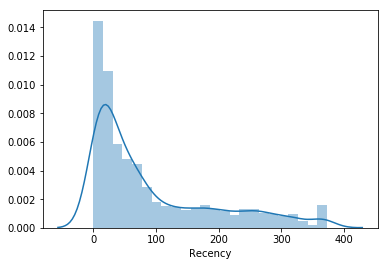

In [21]:
sns.distplot(rfm_scores['Recency'])

* We can see that the data is right skewed

### Plotting a distribution plot on Frequency feature

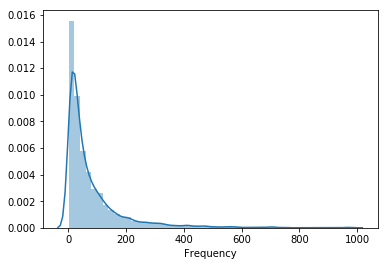

In [22]:
# Taking observations which have frequency less than 1000
x = rfm_scores.query('Frequency < 1000')['Frequency']

sns.distplot(x)

### Plotting a distribution plot on Monetary feature

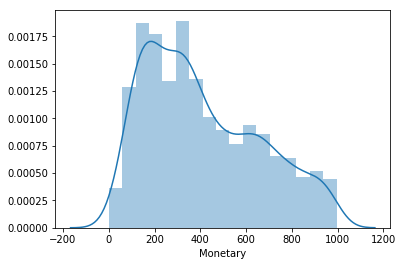

In [23]:
x = rfm_scores.query('Monetary < 1000')['Monetary']

sns.distplot(x)

### Splitting into four segments using quantiles

### What are quantiles ?
* Quantiles are statistics that describe various subdivisions of a frequency distribution into equal proportions. The simplest division that can be envisioned is into two equal halves and the quantile that does this, the median value of the variate, is used also as a measure of central tendency for the distribution.

* **Quant** basically means 25% percentile.

* 1st **Quantile** - 25%, 2nd **Quantile** - 50%, 3rd **Quantile** - 75%, 4th **Quantile** - 100%

* You can choose the quantile range according to your business requirement.

In [24]:
quantiles = rfm_scores.quantile(q=[0.25, 0.50, 0.75])
quantiles = quantiles.to_dict()

In [25]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [26]:
# Functions to create R, F and M segments

def r_scoring(x,p,d):   # Recency function lower the recency value its better for the company
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def f_n_scoring(x,p,d):  # Frequency and monetary function higher the value better it is 
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

### Calculating and adding the R, F and M segment value columns in the existing dataset to show R,F,M segment values

In [27]:
rfm_scores['R'] = rfm_scores['Recency'].apply(r_scoring, args=('Recency', quantiles))
rfm_scores['F'] = rfm_scores['Frequency'].apply(f_n_scoring, args=('Frequency', quantiles))
rfm_scores['M'] = rfm_scores['Monetary'].apply(f_n_scoring, args=('Monetary', quantiles))
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [28]:
# Calculate and add rfm_group value column showing combined concatenated score of RFM

rfm_scores['RFMGroup'] = rfm_scores.R.map(str) + rfm_scores.F.map(str) + rfm_scores.M.map(str)

# Calculate and add RFMscore value column showing total sum of RFMGroup values

rfm_scores['RFMScores'] = rfm_scores[['R', 'F', 'M']].sum(axis=1)

In [29]:
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScores
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


* The lower the value of RFMScore is the more loyal the customer would be as well as more engaged he would be with the brand.

### Assigning loyalty level to each customers

In [30]:
loyalty_level = ['Platinum', 'Gold', 'Silver', 'Bronze']
score_cuts = pd.qcut(rfm_scores.RFMScores, q = 4, labels=loyalty_level)
rfm_scores['RFM_loyalty_levels'] = score_cuts.values
rfm_scores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScores,RFM_loyalty_levels
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


* we can see that the customers with rfm score 441 is assinged with silver and the customers witg rfm scores 111 is assingned with platinum.

In [31]:
rfm_scores.RFMGroup.unique()

array(['441', '111', '122', '444', '322', '341', '333', '133', '231',
       '233', '433', '311', '212', '411', '332', '223', '222', '324',
       '443', '321', '312', '422', '343', '344', '211', '423', '112',
       '243', '142', '234', '121', '442', '221', '131', '134', '334',
       '213', '244', '421', '143', '434', '144', '431', '113', '432',
       '132', '331', '242', '342', '424', '323', '123', '232', '224',
       '124', '412', '241', '313', '413', '141', '114'], dtype=object)

In [32]:
# Validating the data with RFM score 

rfm_scores[rfm_scores['RFM_loyalty_levels'] == 'Bronze'].sort_values('Monetary', ascending=False).reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScores,RFM_loyalty_levels
0,14000.0,211,15,635.66,4,4,3,443,11,Bronze
1,14377.0,191,11,617.05,4,4,3,443,11,Bronze
2,14905.0,157,17,616.15,4,4,3,443,11,Bronze
3,15381.0,213,8,596.85,4,4,3,443,11,Bronze
4,15442.0,248,2,594.00,4,4,3,443,11,Bronze


* These are the people with the Bronze royalty level and which are on the verge oof churning out. Based on this rfm score the company should develop some strategies to retain these customers.

# K-means clustering

![K-means](https://miro.medium.com/max/1280/1*5UHmgCaTD8EegsPuKcxC1Q.png)

### Why do we need to perform k-means clustering?
* Well the businesses around the world would like to understand customer purchase behaviour that these customer groups can be send the relevent promotions and customer segmentation allows the these businesses to create personalized offers for each individual groups.

### What is K-means clustering algorithm ?
* **K-means clustering** is an **unsupervised** machine learning algorithm which makes ***clusters or a group*** of data points based on the distance between the points i.e we divide the data into groups based on the patterns in the data such that all the data points in the cluster should be similar to each other.
* The main **aim** of k-means clustering is to **minimize the sum of distance between the points and their respective cluster centroid.**
* **K** in k-means represents the number of clusters
* The distance between two centeroids are calculated based on the **Eucledian Distance**.

![Eucledian distance](https://miro.medium.com/max/2194/1*tsZFcy6eDc9DuGE9ewL2nQ.jpeg)

### How should I select the k value ?
* To select the k value we basically have a method known as the elbow method.
* The algorithm runs iteratively to assign each data point to one of the k group based on the feature that are already assigned.

## Applications of K-means clustering

### Retail Store :
* The data clustering helps in analyzing the shopping behavious, sales and can be used for customer retention.

### Insurance Company :
* Clustering is deployed in the field of fraud detection, risk factor identification & customer retention efforts.

### Banking :
* It can be used for customer segmentation credit scoring & analyzing customer profitability.

### Its important to normalize and scale the data in order to create these clusters out of the data points because clusters uses distances as similarity factors hence we need to scale the data or normalize it if the data is right skewed or left skewed.

* From our above plot of Recency, Frequency and Monetary distribution plot we saw that our data is right skewed so we need to normalize it before we develop our model.

In [42]:
# Handeling the negative values and zero values so as to handle infinite numbers during log transformation

def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
    
# Applying the handle_neg_n_zero to the Recency and Monetary columns
rfm_scores['Recency'] = [handle_neg_n_zero(x) for x in rfm_scores.Recency]
rfm_scores['Monetary'] = [handle_neg_n_zero(x) for x in rfm_scores.Monetary]

# Performing log transformation to bring the data into normal or near normal distribution
log_tfd_data = rfm_scores[['Frequency','Recency','Monetary']].apply(np.log, axis=1).round(3)

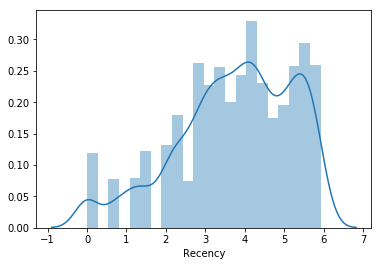

In [43]:
# Distribution plot after data normalization for Recency
sns.distplot(log_tfd_data['Recency'])

In [46]:
# Scaling the data and bringing the data on the same scale

from sklearn.preprocessing import StandardScaler

scaled_obj = StandardScaler()
scaled_data = scaled_obj.fit_transform(log_tfd_data)

# Transforming it back to the dataframe
scaled_data = pd.DataFrame(scaled_data, index = rfm_scores.index, columns=log_tfd_data.columns)

# Building the K-means model

### What is elbow method?

* Elbow method involves running the algorithm in multiple times over a loop within increasing number of cluster  choice and then plotting a clustering score and then plotting a clustering score as the function of the number of clusters. The improvement will decline at some point rapidly creating the elbow shape this is why this method is called as the elbow method.

* We take the count of cluster at the where this elbow is bending 

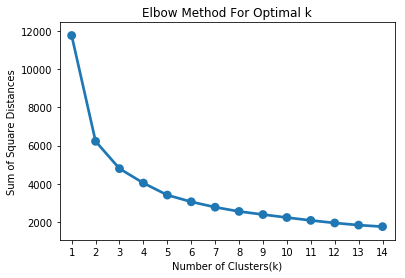

In [49]:
from sklearn.cluster import KMeans

sum_of_sqr_dist = {}
for k in range(1, 15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km = km.fit(scaled_data)
    sum_of_sqr_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sqr_dist.keys()), y = list(sum_of_sqr_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

* In our case we can see that the sum of square distances is dramatically decreasing at k=3 of the elbow of this line so 3 is the optimal value of k in our case.

In [51]:
# Building the k-means clustering model

kmeans_cluster = KMeans(n_clusters=3, init='k-means++', max_iter=1000)
kmeans_cluster.fit(scaled_data)

# Finding the clusters for observation in the given dataset.
rfm_scores['Cluster'] = kmeans_cluster.labels_

rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScores,RFM_loyalty_levels,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,1
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2


<Figure size 504x504 with 0 Axes>

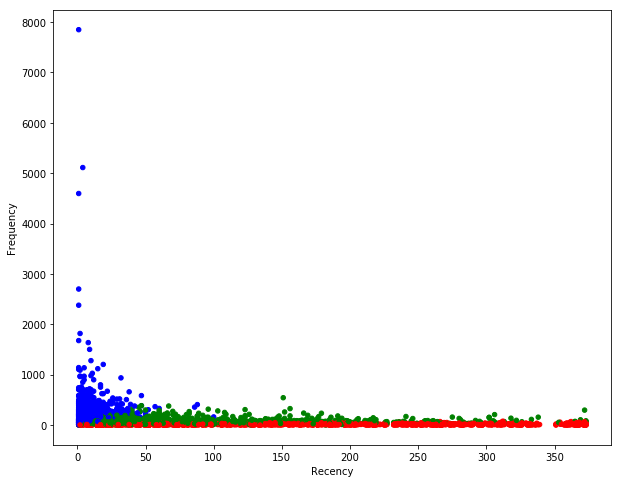

In [52]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
rfm_scores['Color'] = rfm_scores['Cluster'].map(lambda p: Colors[p])
ax = rfm_scores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = rfm_scores['Color']
)